In [1]:
#Imports
import random
import geohash
import geotools
import networkx as nx
import numpy as np
import scipy.spatial as spatial
%matplotlib inline

<h2>Geographic Sims</h2>

In [87]:
def generate_nodes(N,pop_min_max,lat_min_max,lon_min_max):
    '''Generate a normally random dictionary of N geographic nodes with data dictionary of node population and lat/lon coords
    N = numer of nodes
    pop_min_max = tuple of [min,max] population thresholds
    lat_min_max = tuple of [min,max] latitude thresholds
    lon_min_max = tuple of [min,max] longitude thresholds
    '''
    
    node_dict = {}
    for node in range(N):
        lat = random.uniform(*lat_min_max)
        lon = random.uniform(*lon_min_max)
        gh = geohash.encode(lat,lon)
        node_dict[gh] = {'pop':random.randint(*pop_min_max),
                           'lat':lat,
                           'lon':lon,
                           'geohash':gh
                          }
    return node_dict

def generate_network(node_dict,max_connect_dist,link_prob):
    seen_edges = []
    G = nx.Graph()
    for node,data in node_dict.items():
        if node not in G.nodes():
            G.add_node(node,attr_dict=data)
        possible_connections = geotools.get_close_ghs(data['geohash'],G.nodes(),max_connect_dist)
        for connection_node in possible_connections:
            edge_hash = ''.join(sorted([node,connection_node]))
            if random.random() <= link_prob and edge_hash not in seen_edges:
                G.add_edge(node,connection_node)
            seen_edges.append(edge_hash)
    return G

In [85]:
node_dict = generate_nodes(10,[10,100],[30.,70],[40,50])
G = generate_network(node_dict,0.1,0.1)

tj89vxxhz4ggtj89vxxhz4gg


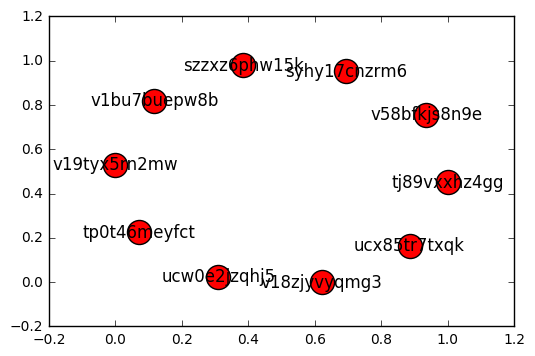

In [86]:
nx.draw_networkx(G)

<h2>Distance Weighted Random Geometric Graph Sims</h2>

In [99]:
def link_prob_vs_distance(distance,max_distance):
    return 1 - distance/max_distance

def distance_weighted_RGG(N,max_distance,dimensions=2):
    G = nx.Graph()
    cord_points = []
    for node in range(N):
        cords = [random.random() for dim in range(dimensions)]
        G.add_node(node,cords=cords)
        cord_points.append(cords)
    point_tree = spatial.cKDTree(points)
    for node,data in G.nodes_iter(data=True):
        close_nodes = [nd for nd in point_tree.query_ball_point(data['cords'],max_distance) if nd != node]
        for connect_node in close_nodes:
            dist = spatial.distance.euclidean(data['cords'],G.node[connect_node]['cords'])
            link_prob = link_prob_vs_distance(dist,max_distance)
            if random.random() <= link_prob:
                G.add_edge(node,connect_node)
    return G

In [100]:
G = distance_weighted_RGG(10,2)

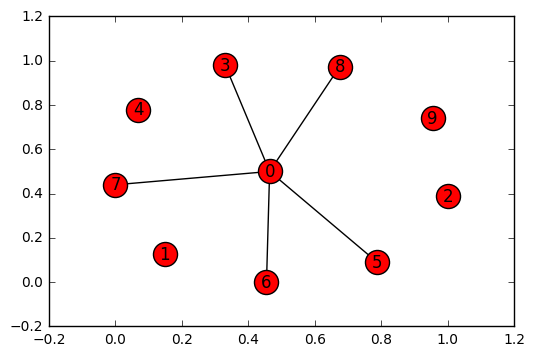

In [101]:
nx.draw_networkx(G)